# ML - Fall 2023 - Practical 5

## Decision Trees

Student Name: Niki Sepasian

Student Number: 400105003 

In [2]:
! pip install optuna
! pip install catboost
! pip install gdown

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import make_scorer, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [4]:
!gdown 'https://drive.google.com/uc?id=1bhS_RnzzU-NgW8Hgc_03Tl4EOlK-8cJr'

Downloading...
From: https://drive.google.com/uc?id=1bhS_RnzzU-NgW8Hgc_03Tl4EOlK-8cJr
To: /kaggle/working/train.csv
100%|████████████████████████████████████████| 170k/170k [00:00<00:00, 87.5MB/s]


# P1: Explore (13 points)

Load the dataset as a dataframe 

In [5]:
df= pd.read_csv('train.csv')

Inspect the first rows of the dataframe **(P1-1: 1 point)**

In [6]:
df.head(5)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,29,No,Travel_Rarely,592,Research & Development,7,3,Life Sciences,1,1883,...,2,80,0,11,2,3,3,2,1,2
1,36,No,Travel_Rarely,884,Sales,1,4,Life Sciences,1,1585,...,1,80,0,15,5,3,1,0,0,0
2,34,No,Travel_Rarely,1326,Sales,3,3,Other,1,1478,...,4,80,0,15,2,3,13,9,3,12
3,27,No,Travel_Rarely,954,Sales,9,3,Marketing,1,1965,...,1,80,0,7,5,3,7,7,0,7
4,32,No,Travel_Rarely,929,Sales,10,3,Marketing,1,722,...,4,80,0,10,2,2,10,7,0,8


Calculate the number of samples **(P1-2: 0.5 point)**

In [7]:
df.shape[0]

1102

Measure the number of unique values for each column. Note that `Attrition` is the target column. **(P1-3: 1.5 points)**

In [8]:
unique_counts= {}
for col in df:
    unique_counts[col]= df[col].nunique()
unique_counts

{'Age': 43,
 'Attrition': 2,
 'BusinessTravel': 3,
 'DailyRate': 736,
 'Department': 3,
 'DistanceFromHome': 29,
 'Education': 5,
 'EducationField': 6,
 'EmployeeCount': 1,
 'EmployeeNumber': 1102,
 'EnvironmentSatisfaction': 4,
 'Gender': 2,
 'HourlyRate': 71,
 'JobInvolvement': 4,
 'JobLevel': 5,
 'JobRole': 9,
 'JobSatisfaction': 4,
 'MaritalStatus': 3,
 'MonthlyIncome': 1027,
 'MonthlyRate': 1082,
 'NumCompaniesWorked': 10,
 'Over18': 1,
 'OverTime': 2,
 'PercentSalaryHike': 15,
 'PerformanceRating': 2,
 'RelationshipSatisfaction': 4,
 'StandardHours': 1,
 'StockOptionLevel': 4,
 'TotalWorkingYears': 40,
 'TrainingTimesLastYear': 7,
 'WorkLifeBalance': 4,
 'YearsAtCompany': 34,
 'YearsInCurrentRole': 19,
 'YearsSinceLastPromotion': 16,
 'YearsWithCurrManager': 17}

Check if there is a column with less than two unique values. If such a columns exists, remove it! **(P1-4: 1.5 points)**

In [9]:
print("colmuns with less than 2 unique values: ")
for key, value in unique_counts.items():
    if value<2:
        print(key)
        df.drop(key, axis= 1, inplace= True)

colmuns with less than 2 unique values: 
EmployeeCount
Over18
StandardHours


Plot Mean `BusinessTravel` against `Age`. Note: Since the `BusinessTravel` column is categorical, you should first consider another column corresponding to each unique value `BusinessTravel` takes. For instance, you may assume that if someone does not travel, the value of the column for this person is 0. **(P1-5: 2.5 points)**

In [10]:
# handle uniqueness
df['BusinessTravel'].unique()

array(['Travel_Rarely', 'Travel_Frequently', 'Non-Travel'], dtype=object)

In [11]:
# Map the column
encoding= {'Travel_Rarely':1, 'Travel_Frequently':2, 'Non-Travel':0}
df['EncodedBusinessTravel']= df['BusinessTravel'].map(encoding)
df.head(5)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,EncodedBusinessTravel
0,29,No,Travel_Rarely,592,Research & Development,7,3,Life Sciences,1883,4,...,2,0,11,2,3,3,2,1,2,1
1,36,No,Travel_Rarely,884,Sales,1,4,Life Sciences,1585,2,...,1,0,15,5,3,1,0,0,0,1
2,34,No,Travel_Rarely,1326,Sales,3,3,Other,1478,4,...,4,0,15,2,3,13,9,3,12,1
3,27,No,Travel_Rarely,954,Sales,9,3,Marketing,1965,4,...,1,0,7,5,3,7,7,0,7,1
4,32,No,Travel_Rarely,929,Sales,10,3,Marketing,722,4,...,4,0,10,2,2,10,7,0,8,1


<Axes: xlabel='EncodedBusinessTravel', ylabel='Age'>

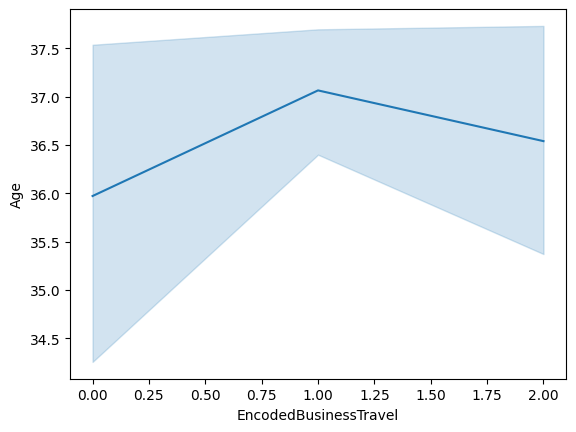

In [12]:
# plot
sns.lineplot(data= df, x= 'EncodedBusinessTravel', y= 'Age')

Find the `Department` in which the least amount of time has passed since the last promotion of the employees on average. **(P1-6: 1 point)**

In [13]:
df.groupby('Department')['YearsSinceLastPromotion'].mean().idxmin()

'Human Resources'

Check if there seems to be a meaningful relationship between people's age and the years they have worked with their current manager. Your result should be a plot. **(P1-7: 2 points)**

Not a so consistant meaningful relationship, but it's evident that younger people do not keep on working with the same manager for too long and they start to settle down with the same manger as they grow older.

<Axes: xlabel='Age', ylabel='YearsWithCurrManager'>

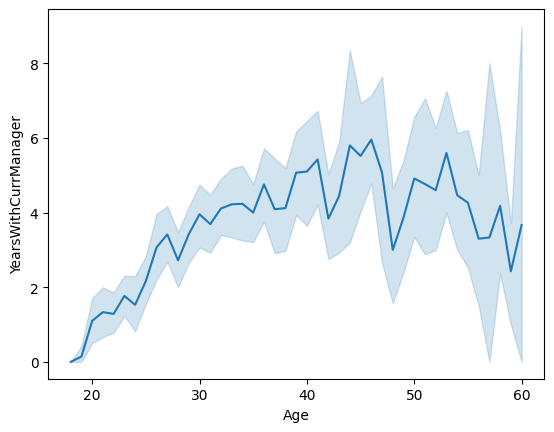

In [14]:
sns.lineplot(data= df, y= 'YearsWithCurrManager', x= 'Age')

Compare the average `JobSatisfaction` for employees whose `JobRole` is `Research Scientist`, `Human Resources`, `Manager`, or `Research Director` using a plot.  **(P1-8: 2 points)**

<Axes: xlabel='Department'>

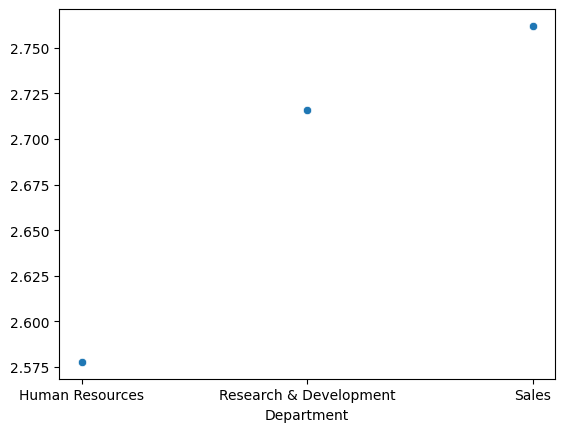

In [15]:
avg_satisfaction= df.groupby('Department')['JobSatisfaction'].mean()
sns.scatterplot(x= avg_satisfaction.index, y= avg_satisfaction.values)

Plot the average `MonthlyIncome` against the `YearsAtCompany`. **(P1-9: 1 point)**

<Axes: xlabel='YearsAtCompany', ylabel='MonthlyIncome'>

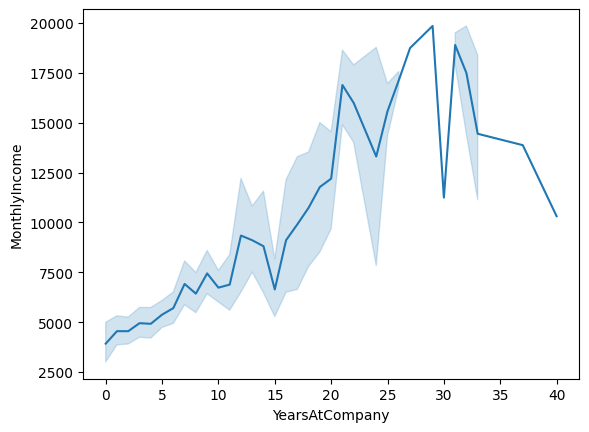

In [16]:
sns.lineplot(data= df, x= 'YearsAtCompany', y= 'MonthlyIncome')

# P2: Pre-processing (9 points)

Label encode all categorical columns and split the data into train and test parts. The training part will further splitted into train and validation parts. **(P2-1: 2.5 points)**

In [17]:
# Label encode  (1.5 points)
df= df.drop('EncodedBusinessTravel', axis=1)
encoded_df= df.copy()
for col in encoded_df.columns:
    if encoded_df[col].dtype=='object':
        encoded_df[col]=LabelEncoder().fit_transform(encoded_df[col])
encoded_df.head(5)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,29,0,2,592,1,7,3,1,1883,4,...,3,2,0,11,2,3,3,2,1,2
1,36,0,2,884,2,1,4,1,1585,2,...,3,1,0,15,5,3,1,0,0,0
2,34,0,2,1326,2,3,3,4,1478,4,...,3,4,0,15,2,3,13,9,3,12
3,27,0,2,954,2,9,3,2,1965,4,...,3,1,0,7,5,3,7,7,0,7
4,32,0,2,929,2,10,3,2,722,4,...,3,4,0,10,2,2,10,7,0,8


In [18]:
# split into train and validation (0.5 point)
from sklearn.model_selection import train_test_split

train_df, test_df= train_test_split(encoded_df, train_size= 0.8, shuffle= True)

In [19]:
# lens of train and validation datasets (0.5 point)
print("train size: ", train_df.shape)
print("test size (before validation test size): ", test_df.shape)

train size:  (881, 32)
test size (before validation test size):  (221, 32)


Further split the test dataframe into validation and test dataframes. **(P2-2: 0.5 point)**

In [20]:
validation_df, test_df= train_test_split(test_df, train_size= 0.5, shuffle= True)
print("test size: ", test_df.shape)
print("validation size: ", validation_df.shape)

test size:  (111, 32)
validation size:  (110, 32)


Split the test and validation dataframe into feature and label part, Attrition columns is the target columns and rest of the columns should be treated as features. **(P2-3: 1 point)**

In [21]:
y_test = test_df['Attrition'].values
x_test = test_df.drop('Attrition', axis=1).values

y_val = validation_df['Attrition'].values
x_val = validation_df.drop('Attrition', axis=1).values

In [22]:
y_val.shape

(110,)

check if the training dataset is label balanced. **(P2-4: 2 points)**

In [23]:
train_df['Attrition'].value_counts()

Attrition
0    728
1    153
Name: count, dtype: int64

Balance the training dataset by oversampling the class with less samples. **(P2-5: 2 points)**

Don't know oversampling? Read [this link](https://deeptip.ir/oversampling-and-undersampling-in-python/) (5 minutes)

In [24]:
# oversampling (1.5 points)
from imblearn.over_sampling import RandomOverSampler

resampled_x, resampled_y= RandomOverSampler(sampling_strategy='minority').fit_resample(train_df.drop('Attrition', axis=1), train_df['Attrition'])

In [25]:
# check if dataset is balanced (0.5 point)
resampled_y.value_counts()

Attrition
1    728
0    728
Name: count, dtype: int64

Split the training dataframe into feature and target columns. **(P2-6: 1 point)**

In [26]:
x_train = resampled_x.values
y_train = resampled_y.values

# P3: Decision tree from scratch (20 points)
Don't know Decision Tree? Read [this link](https://betterdatascience.com/mml-decision-trees/) (25 minutes).

Watch an introduction to Decision Trees [here](https://www.youtube.com/watch?v=J4Wdy0Wc_xQ&list=PLblh5JKOoLUIE96dI3U7oxHaCAbZgfhHk) (10 minutes).

Implement decision tree based on the given functions. **(P3-1: 15 points)**

The given functions are not mandatory, you can add or remove any functions if needed.

In [27]:
import numpy as np

class DecisionTree:

    def __init__(self, max_depth):
        self.max_depth= max_depth
        self.decision_tree= {}

    def _compute_entropy(self, y):
        uniques,counts= np.unique(y, return_counts=True)
        prob= counts/len(y)
        return (-np.sum((prob)*np.log2(prob)))
    
    
    def _information_gain(self, left, right, y):
        left_entropy= self._compute_entropy(left)
        right_entropy= self._compute_entropy(right)
        return self._compute_entropy(y) - ((len(left)*left_entropy + len(right)*right_entropy)/len(y))
    
    
    def _split_data(self, X, y, feature_index, threshold):
        l_index= X[:, feature_index]<=threshold
        
        X_left= X[l_index]
        y_left= y[l_index]
        
        X_right= X[~l_index]
        y_right =y[~l_index]
        
        return X_left, y_left, X_right, y_right
    
    def _find_best_split(self, X, y):
        max_IG= -float('inf')
        best_feature= None
        best_threshold= None

        for feature in range(X.shape[1]):
            thresholds= np.unique(X[:, feature])
            for threshold in thresholds:
                X_left, y_left, X_right, y_right = self._split_data(X, y, feature, threshold)
                
                if len(y_left)==0 or len(y_right)==0:
                    continue
                
                IG= self._information_gain(y_left, y_right, y)
                
                if IG>max_IG:
                    max_IG= IG
                    best_feature= feature
                    best_threshold= threshold

        return best_feature, best_threshold

    def _build_tree(self, X, y, depth):
        if depth==0 or len(np.unique(y))==1:
            return {'value': np.bincount(y).argmax()}

        best_feature, best_threshold= self._find_best_split(X, y)

        if best_feature is None:
            return {'value': np.bincount(y).argmax()}

        X_left, y_left, X_right, y_right= (self._split_data(X, y, best_feature, best_threshold))

        return {
            'feature': best_feature,
            'threshold': best_threshold,
            'left': self._build_tree(X_left, y_left, depth-1),
            'right': self._build_tree(X_right, y_right, depth-1)
        }


    def fit(self, X, y):
        self.decision_tree= self._build_tree(X, y, self.max_depth)

    def _predict_sample(self, x, decision_tree):
        if 'value' in decision_tree:
            return decision_tree['value']

        if x[decision_tree['feature']]<=decision_tree['threshold']:
            return self._predict_sample(x, decision_tree['left'])

        return self._predict_sample(x, decision_tree['right'])

    def predict(self, X):
        return np.array([self._predict_sample(x, self.decision_tree) for x in X])


Define the model and train it. **(P3-2: 1 point)**

In [28]:
# model decleration and training
scratch_model = DecisionTree(15)
scratch_model.fit(x_train, y_train)

Predict the y_train and y_val values. **(P3-3: 1 point)**

In [29]:
# model predictions
y_train_pred = scratch_model.predict(x_train)
y_val_pred = scratch_model.predict(x_val)

In [30]:
print(f'Train and validation accuracy are: {accuracy_score(y_train, y_train_pred)}, \
      {accuracy_score(y_val, y_val_pred)}')

print(f'Train and validation recall are: {recall_score(y_train, y_train_pred)}, \
      {recall_score(y_val, y_val_pred)}')

print(f'Train and validation f1 are: {f1_score(y_train, y_train_pred)}, \
      {f1_score(y_val, y_val_pred)}')

Train and validation accuracy are: 0.9972527472527473,       0.7545454545454545
Train and validation recall are: 0.9945054945054945,       0.5263157894736842
Train and validation f1 are: 0.9972451790633609,       0.425531914893617


Visulize (y_train, y_train_pred) using Heatmap **(P3-4: 1.5 points)**

<Axes: >

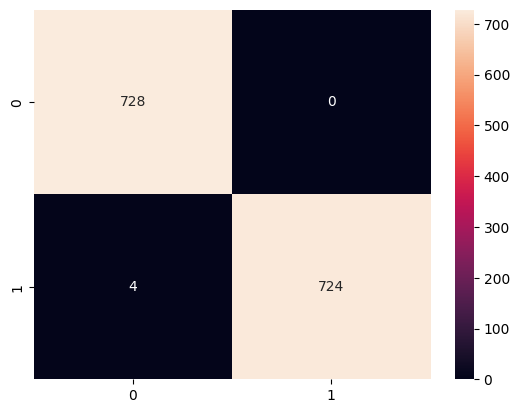

In [60]:
# src: https://www.geeksforgeeks.org/seaborn-heatmap-a-comprehensive-guide/ (6 minutes)
# src: https://blog.faradars.org/confusion-matrix-from-zero-to-hero/ (5 minutes)
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, fmt='d', cmap='rocket')

Visulize (y_val, y_val_pred) using Heatmap **(P3-5: 1.5 points)**

<Axes: >

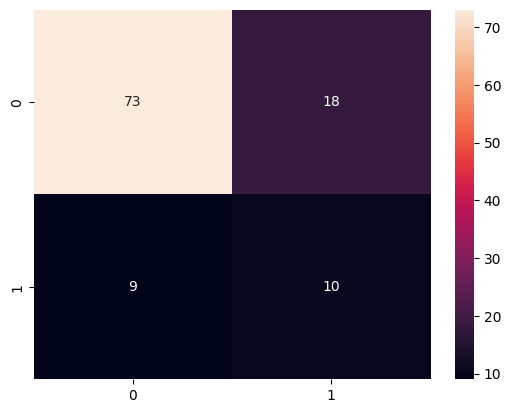

In [61]:
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt='d', cmap='rocket')

# P4: Random forest from scratch (20 points)
Don't know Random Forest? Read [this link](https://quera.org/blog/random-forest-algorithm/) (15 minutes).

Implement Random Forest based on the given functions. **(P4-1: 15 points)**

The given functions are not mandatory, you can add or remove any functions if needed.

In [94]:
class RandomForest:
    def __init__(self, num_trees=10, max_depth=None, random_state=None, max_features=None):
        self.num_trees= num_trees
        self.max_depth= max_depth
        self.random_state= random_state
        self.max_features= max_features
        self.trees= []
        
    def bootstrap_sampling(self, X, y):    
        selected_features= X.shape[1]
        if self.max_features is not None:
            selected_features= np.random.choice(X.shape[1], size=self.max_features, replace=False)

        selected_samples= list(np.random.choice(range(len(X)), size=len(X), replace=True))
        return X[selected_samples, :selected_features], y[selected_samples], selected_features

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.trees= []

        for i in range(self.num_trees):
            bootstrap_x, bootstrap_y, selected_features= self.bootstrap_sampling(X, y)
            tree= DecisionTree(max_depth= self.max_depth)
            tree.fit(bootstrap_x, bootstrap_y)
            self.trees.append((tree, selected_features))

    def predict(self, X):
        preds= np.zeros((X.shape[0], self.num_trees))
        
        for i in range(len(self.trees)):
            tree= self.trees[i][0]
            features= self.trees[i][1]
            preds[:, i]= tree.predict(X[:, :features])
        
        return np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=1, arr=preds)



Define the model and train it. **(P4-2: 1 point)**

In [95]:
forest_scratch_model= RandomForest(num_trees=10, max_depth=15, random_state=42, max_features=None)
forest_scratch_model.fit(x_train, y_train)

Predict the y_train and y_val values. **(P4-3: 1 point)**

In [96]:
y_train_pred = forest_scratch_model.predict(x_train)
y_val_pred =  forest_scratch_model.predict(x_val)

In [97]:
print(f'Train and validation accuracy are: {accuracy_score(y_train, y_train_pred)}, \
      {accuracy_score(y_val, y_val_pred)}')

print(f'Train and validation recall are: {recall_score(y_train, y_train_pred)}, \
      {recall_score(y_val, y_val_pred)}')

print(f'Train and validation f1 are: {f1_score(y_train, y_train_pred)}, \
      {f1_score(y_val, y_val_pred)}')

Train and validation accuracy are: 0.9986263736263736,       0.7727272727272727
Train and validation recall are: 1.0,       0.3157894736842105
Train and validation f1 are: 0.9986282578875172,       0.3243243243243243


Visulize (y_train, y_train_pred) using Heatmap **(P4-4: 1.5 points)**

<Axes: >

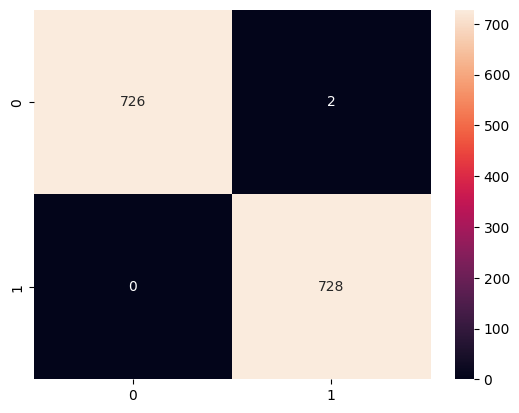

In [98]:
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, fmt='d', cmap='rocket')

Visulize (y_val, y_val_pred) using Heatmap **(P4-5: 1.5 points)**

<Axes: >

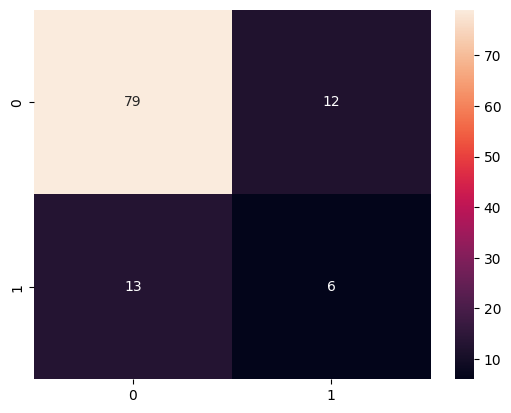

In [99]:
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt='d', cmap='rocket')

# P5: Decision Tree (10 points)

Fit the data to a decision tree (of sklearn) with maximum depth of 2. **(P5-1: 2 points)**

In [101]:
# Model definition
sklearn_model = DecisionTreeClassifier(max_depth= 2)  
# Model fitting
sklearn_model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=2)

Plot the fitted decision tree. **(P5-2: 2 points)**

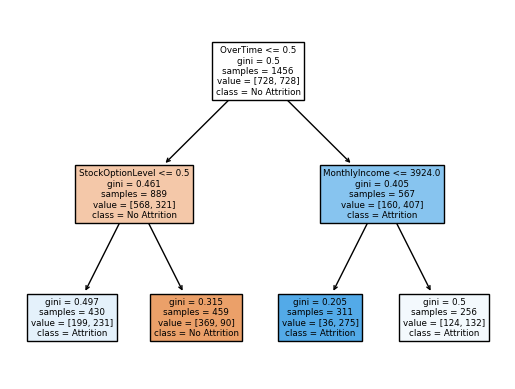

In [110]:
from sklearn import tree

tree.plot_tree(sklearn_model, feature_names=resampled_x.columns, class_names=['No Attrition', 'Attrition'], filled=True)
plt.show()

Make predictions on training and validation set and calculate accuracy, recall and f1_score on them. **(P5-3: 1 point)**

In [111]:
y_train_pred = sklearn_model.predict(x_train)
y_val_pred = sklearn_model.predict(x_val)

In [112]:
print(f'Train and validation accuracy are: {accuracy_score(y_train, y_train_pred)}, \
      {accuracy_score(y_val, y_val_pred)}')

print(f'Train and validation recall are: {recall_score(y_train, y_train_pred)}, \
      {recall_score(y_val, y_val_pred)}')

print(f'Train and validation f1 are: {f1_score(y_train, y_train_pred)}, \
      {f1_score(y_val, y_val_pred)}')

Train and validation accuracy are: 0.6916208791208791,       0.4090909090909091
Train and validation recall are: 0.8763736263736264,       0.8421052631578947
Train and validation f1 are: 0.7397101449275363,       0.32989690721649484


Plot the confusion matrices for the training and validation datasets. **(P5-4: 2 points)**

<Axes: >

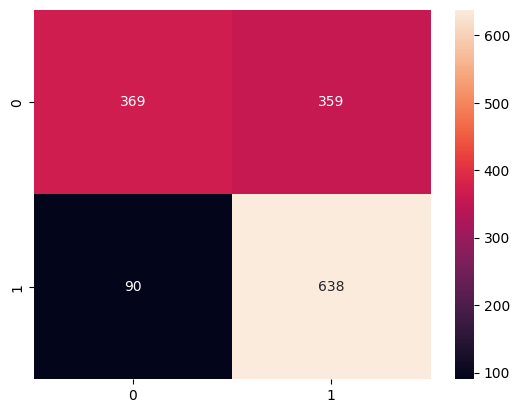

In [113]:
# 1 point for (y_train, y_train_pred)
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, fmt='d', cmap='rocket')

<Axes: >

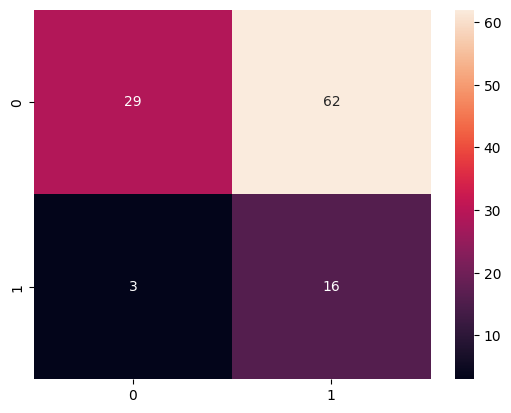

In [114]:
# 1 point for (y_val, y_val_pred)
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt='d', cmap='rocket')

Experiment with different depth trees and plot the f1_score associated with each depth on training and valication datasets. **(P5-5: 3 points)**

<Axes: xlabel='Depth', ylabel='value'>

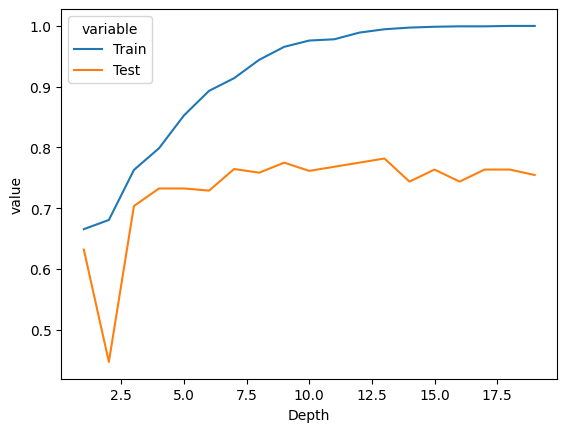

In [115]:
depths= range(1, 20)
t_scores= []
v_scores= []

for depth in depths:
    tree= DecisionTreeClassifier(max_depth= depth)
    tree.fit(x_train, y_train)

    y_train_pred= tree.predict(x_train)
    y_val_pred= tree.predict(x_val)

    t_scores.append(f1_score(y_train, y_train_pred, average='weighted'))
    v_scores.append(f1_score(y_val, y_val_pred, average='weighted'))
plot_data = pd.DataFrame({
    'Depth': depths, 
    'Train': t_scores,
    'Test': v_scores})
sns.lineplot(x='Depth', y='value', hue='variable', data=pd.melt(plot_data, ['Depth']))

# P6: Random Forest (7 points)

Fit the training data to a random forest (of sklearn). **(P6-1: 2 points)**

In [117]:
# Model definition
sklearn_forest_model = RandomForestClassifier(n_estimators=100, random_state= 42)
# Model fitting
sklearn_forest_model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

Plot the feature importances using a bar plot. **(P6-2: 2 points)**

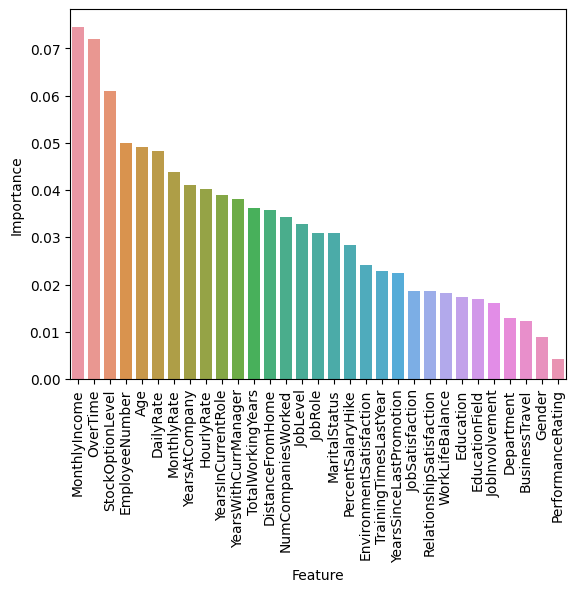

In [126]:
imps= sklearn_forest_model.feature_importances_
indices= np.argsort(imps)[::-1]
importance_df= pd.DataFrame({'Feature': resampled_x.columns[indices], 'Importance': imps[indices]})

sns.barplot(data= importance_df, x='Feature', y='Importance').tick_params(axis='x', rotation=90)

Make predictions using the model and print the accuracy, recall, f1_score and plot the confusion matrices for training and validation data. **(P6-3: 1 point)**

In [127]:
y_train_pred = sklearn_forest_model.predict(x_train)
y_val_pred = sklearn_forest_model.predict(x_val)

In [128]:
print(f'Train and validation accuracy are: {accuracy_score(y_train, y_train_pred)}, \
      {accuracy_score(y_val, y_val_pred)}')

print(f'Train and validation recall are: {recall_score(y_train, y_train_pred)}, \
      {recall_score(y_val, y_val_pred)}')

print(f'Train and validation f1 are: {f1_score(y_train, y_train_pred)}, \
      {f1_score(y_val, y_val_pred)}')

Train and validation accuracy are: 1.0,       0.8545454545454545
Train and validation recall are: 1.0,       0.47368421052631576
Train and validation f1 are: 1.0,       0.5294117647058824


Plot the confusion matrices for the training and validation datasets. **(P6-4: 2 points)**

<Axes: >

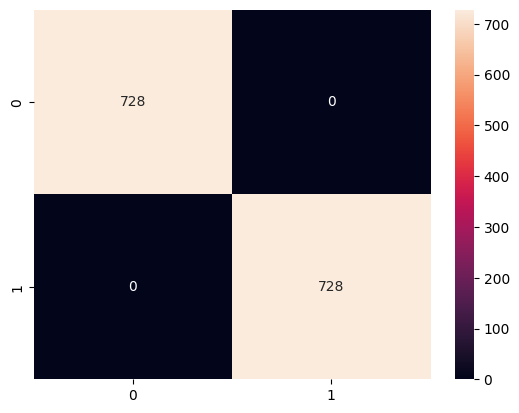

In [129]:
# 1 point for (y_train, y_train_pred)
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, fmt='d', cmap='rocket')

<Axes: >

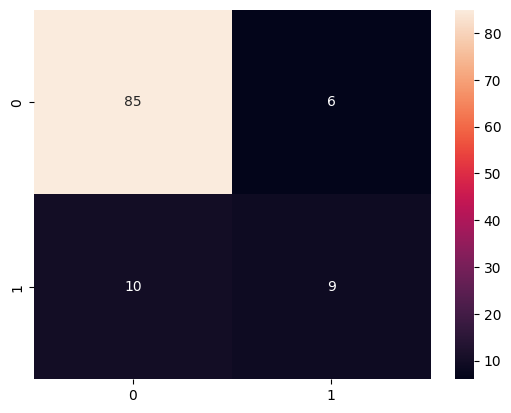

In [130]:
# 1 point for (y_val, y_val_pred)
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt='d', cmap='rocket')

# P7: Gradient Boosted Decision Trees (5 points)
Don't know GBD Tree? Follow [this link](https://www.machinelearningplus.com/machine-learning/an-introduction-to-gradient-boosting-decision-trees/) (+30 minutes).

Fit a gradient boosted decision tree(e.g. catboost, lightgbm, xgboost). **(P7-1: 2 points)**

Using the catboost library is recommended

In [131]:
# Model definition
GBD_model = CatBoostClassifier()
# Model fitting
GBD_model.fit(x_train, y_train)

Learning rate set to 0.012095
0:	learn: 0.6853159	total: 58.5ms	remaining: 58.5s
1:	learn: 0.6800825	total: 61.3ms	remaining: 30.6s
2:	learn: 0.6736867	total: 64ms	remaining: 21.3s
3:	learn: 0.6668808	total: 66.2ms	remaining: 16.5s
4:	learn: 0.6614506	total: 68.5ms	remaining: 13.6s
5:	learn: 0.6553679	total: 70.8ms	remaining: 11.7s
6:	learn: 0.6503893	total: 73.6ms	remaining: 10.4s
7:	learn: 0.6445911	total: 76.1ms	remaining: 9.43s
8:	learn: 0.6377979	total: 78.6ms	remaining: 8.66s
9:	learn: 0.6317691	total: 81.2ms	remaining: 8.04s
10:	learn: 0.6259621	total: 83.7ms	remaining: 7.53s
11:	learn: 0.6219029	total: 86.8ms	remaining: 7.15s
12:	learn: 0.6156241	total: 89.8ms	remaining: 6.81s
13:	learn: 0.6106359	total: 92.9ms	remaining: 6.54s
14:	learn: 0.6064679	total: 95.7ms	remaining: 6.29s
15:	learn: 0.6025922	total: 98.2ms	remaining: 6.04s
16:	learn: 0.5980532	total: 101ms	remaining: 5.82s
17:	learn: 0.5928948	total: 103ms	remaining: 5.62s
18:	learn: 0.5871860	total: 106ms	remaining: 5.4

Make predictions using the model and print the accuracy, recall, f1_score and plot the confusion matrices for training and validation data. **(P7-2: 1 point)**

In [132]:
y_train_pred = GBD_model.predict(x_train)
y_val_pred = GBD_model.predict(x_val)

In [133]:
print(f'Train and test accuracy are: {accuracy_score(y_train, y_train_pred)}, \
      {accuracy_score(y_val, y_val_pred)}')

print(f'Train and test recall are: {recall_score(y_train, y_train_pred)}, \
      {recall_score(y_val, y_val_pred)}')

print(f'Train and test f1 are: {f1_score(y_train, y_train_pred)}, \
      {f1_score(y_val, y_val_pred)}')

Train and test accuracy are: 1.0,       0.8272727272727273
Train and test recall are: 1.0,       0.42105263157894735
Train and test f1 are: 1.0,       0.45714285714285713


Plot the confusion matrices for the training and validation datasets. **(P7-3: 2 points)**

<Axes: >

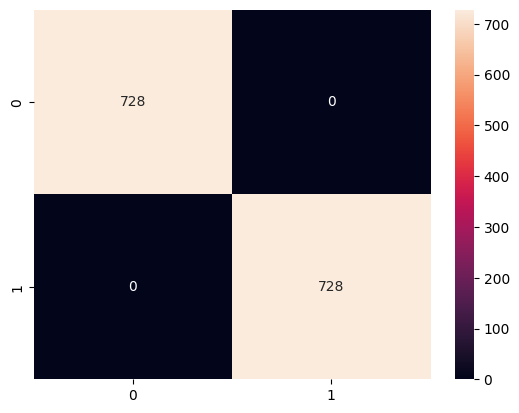

In [134]:
# 1 point for (y_train, y_train_pred)
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, fmt='d', cmap='rocket')

<Axes: >

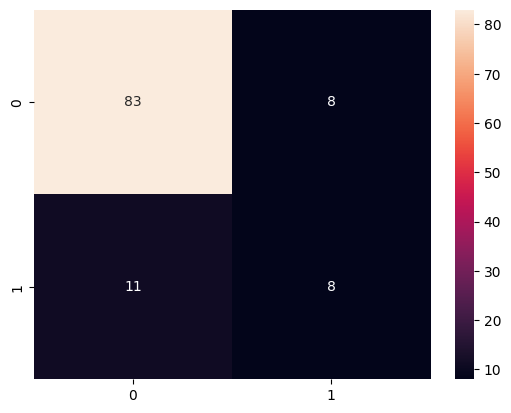

In [135]:
# 1 point for (y_val, y_val_pred)
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt='d', cmap='rocket')

# P8: Tuning parameters using optuna? (12 points)

There are many tunable parameters in Gradient boosted decision trees tuning all of them using grid search is almost impossible. There is no other choice for tuing hyperparameters unless you assume some models on behaviour of models under different hyperparameter choices e.g. the follow a gaussian process. Use the optuna library to tune the hyperparameters of gradient boosted decision tree. Report the results as in the previous parts. **(P8-1: 10 points)**

Do you want to get familiar more with it? Follow [this link](https://datagy.io/python-optuna/) (+40 minutes)

Do you know the difference between parameters and hyperparameters? If no, you can find more [here](https://virgool.io/@maryam.hasanali/%D9%87%D8%A7%DB%8C%D9%BE%D8%B1%D9%BE%D8%A7%D8%B1%D8%A7%D9%85%D8%AA%D8%B1%D9%87%D8%A7%DB%8C-%D8%AF%D8%B1-%DB%8C%DA%A9-%D9%85%D8%AF%D9%84-%DB%8C%D8%A7%D8%AF%DA%AF%DB%8C%D8%B1%DB%8C-%D9%85%D8%A7%D8%B4%DB%8C%D9%86-%DA%86%DB%8C%D8%B3%D8%AA-%D9%88-%DA%86%DA%AF%D9%88%D9%86%D9%87-%D8%A2%D9%86-%D8%B1%D8%A7-%D8%AA%D9%86%D8%B8%DB%8C%D9%85-%DA%A9%D9%86%DB%8C%D9%85-o8zgjoouhwen) (3 minutes).

In [164]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 3, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10),
        'random_strength': trial.suggest_float('random_strength', 0.0, 100.0),
    }
    
    model= CatBoostClassifier(**params, verbose=False)
    model.fit(x_train, y_train, eval_set=(x_val, y_val), verbose=False)
    return f1_score(y_val, model.predict(x_val))

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
trial = study.best_trial
trial.params

[I 2024-01-04 21:02:32,488] A new study created in memory with name: no-name-6996c8bc-ee56-4904-945e-d579c504855e
/tmp/ipykernel_42/1840646967.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
/tmp/ipykernel_42/1840646967.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10),
[I 2024-01-04 21:03:17,520] Trial 0 finished with value: 0.46153846153846156 and parameters: {'iterations': 268, 'depth': 14, 'learning_rate': 0.0071798996750350825, 'l2_leaf_reg': 0.9916426124244756, 'random_strength': 54.453574275701975}. Best is trial 0 with val

{'iterations': 598,
 'depth': 6,
 'learning_rate': 0.026459709372046628,
 'l2_leaf_reg': 2.8271805768791523,
 'random_strength': 69.77789089264532}

In [165]:
model = CatBoostClassifier(**trial.params, verbose=False)
model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)

print(f'Train and test accuracy are: {accuracy_score(y_train, y_train_pred)}, \
      {accuracy_score(y_val, y_val_pred)}')

print(f'Train and test recall are: {recall_score(y_train, y_train_pred)}, \
      {recall_score(y_val, y_val_pred)}')

print(f'Train and test f1 are: {f1_score(y_train, y_train_pred)}, \
      {f1_score(y_val, y_val_pred)}')

Train and test accuracy are: 1.0,       0.8363636363636363
Train and test recall are: 1.0,       0.42105263157894735
Train and test f1 are: 1.0,       0.47058823529411764


Plot the confusion matrices for the training and validation datasets. **(P8-2: 2 points)**

<Axes: >

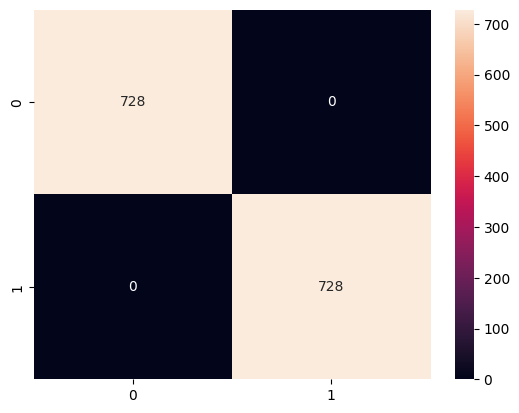

In [166]:
# 1 point for (y_train, y_train_pred)
sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, fmt='d', cmap='rocket')

<Axes: >

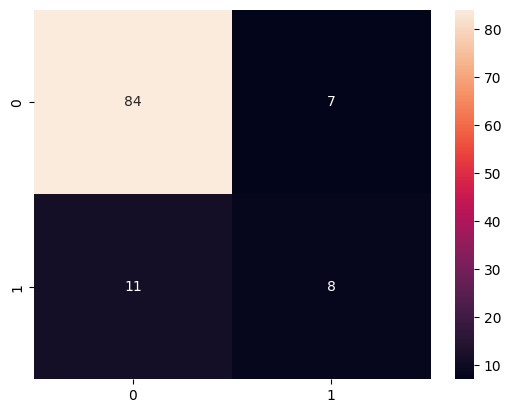

In [167]:
# 1 point for (y_val, y_val_pred)
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt='d', cmap='rocket')

# P9: Performance on testing data (4 points)

call the model on test data. **(P9-1: 1 point)**

In [168]:
y_pred_model = model.predict(x_test)
y_pred_scratch_model= scratch_model.predict(x_test)
y_pred_scratch_forest_model= forest_scratch_model.predict(x_test)
y_pred_sklearn_model= sklearn_model.predict(x_test)
y_pred_sklearn_forest_model= sklearn_forest_model.predict(x_test)
y_pred_GBD_model= GBD_model.predict(x_test)

evaluate your model on the testing data using f1_score. **(P9-2: 1 point)**

In [169]:
print("f1 scores:")
print("from scratch decision tree model: ", f1_score(y_test, y_pred_scratch_model))
print("from scratch random forest model: ", f1_score(y_test, y_pred_scratch_forest_model))
print("sklearn decision tree model: ", f1_score(y_test, y_pred_sklearn_model))
print("sklearn random forest model: ", f1_score(y_test, y_pred_sklearn_forest_model))
print("catboost model: ", f1_score(y_test, y_pred_GBD_model))
print("hyperparameter tuned catboost model: ", f1_score(y_test, y_pred_model))

f1 scores:
from scratch decision tree model:  0.27027027027027023
from scratch random forest model:  0.3448275862068966
sklearn decision tree model:  0.2857142857142857
sklearn random forest model:  0.19047619047619047
catboost model:  0.31999999999999995
hyperparameter tuned catboost model:  0.37037037037037035


What is the origin of loosing performance on the test set? Answer briefly here. **(P9-3: 1 point)**

**It could be due to overfitting and our model having more complexity compared to data's complexity. So the model could have caught training data's noise that could lead to loosing performance.**
\
**As for the catboost model after hyperparameter tuning, it could be that we didn't have enough validation data for our hyperparameter tuning, or that some hyperparameters have been sensitive to small changes, so fine-tuning them has led to overfitting.**

Plot the heatmap of the confusion matrix here. **(P9-4: 1 point)**

Text(0.5, 1.0, 'Hyperparameter Tuned GBD Model')

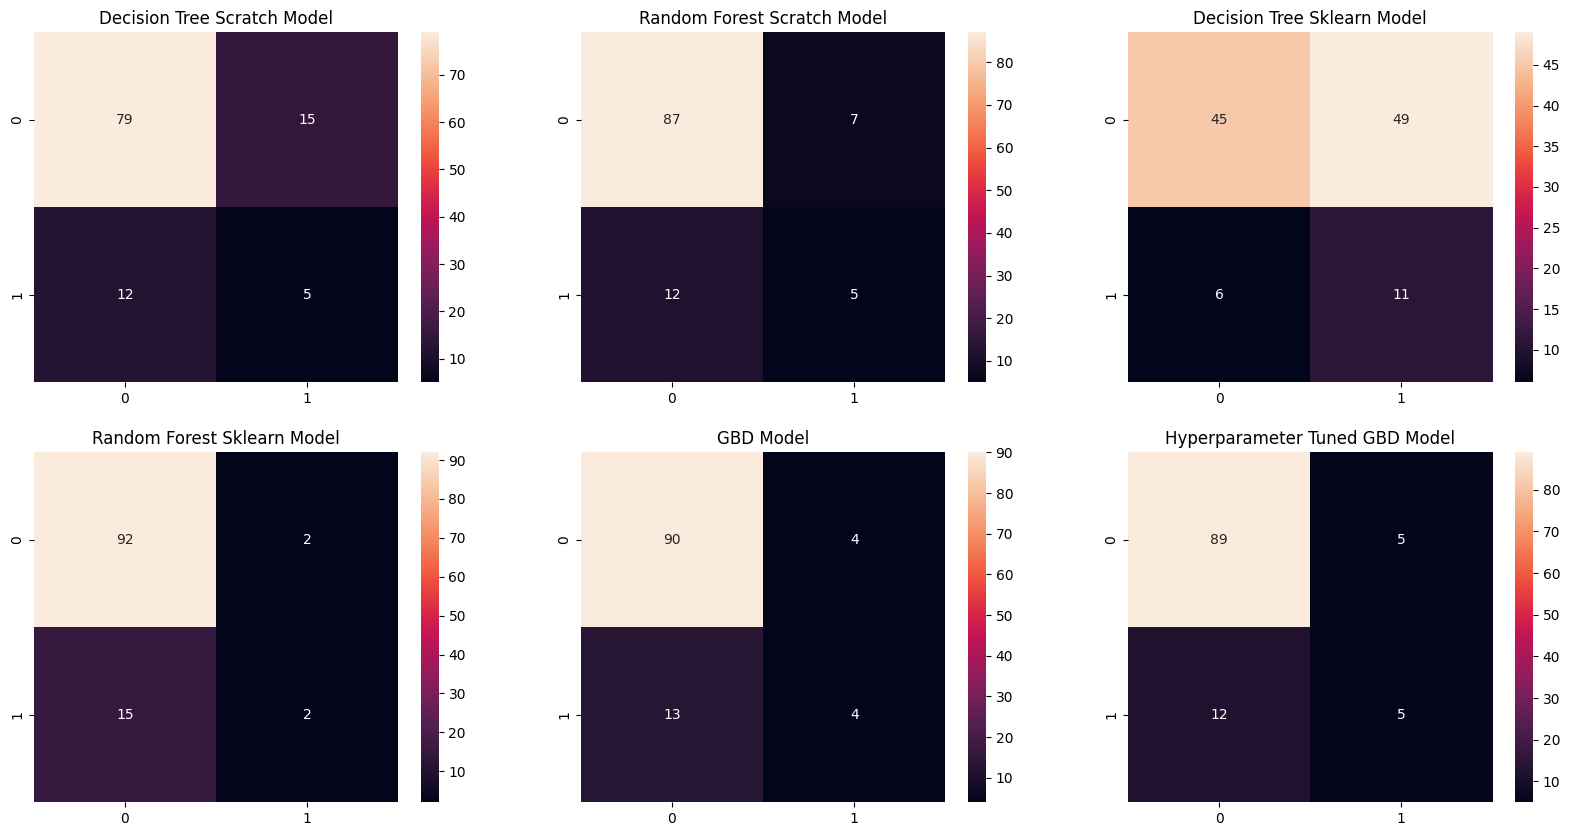

In [179]:
fig, axs= plt.subplots(2,3, figsize=(20, 10))
sns.heatmap(confusion_matrix(y_test, y_pred_scratch_model), annot=True, fmt='d', cmap='rocket', ax=axs[0][0])
axs[0][0].set_title('Decision Tree Scratch Model')

sns.heatmap(confusion_matrix(y_test, y_pred_scratch_forest_model), annot=True, fmt='d', cmap='rocket', ax=axs[0][1])
axs[0][1].set_title('Random Forest Scratch Model')

sns.heatmap(confusion_matrix(y_test, y_pred_sklearn_model), annot=True, fmt='d', cmap='rocket', ax=axs[0][2])
axs[0][2].set_title('Decision Tree Sklearn Model')

sns.heatmap(confusion_matrix(y_test, y_pred_sklearn_forest_model), annot=True, fmt='d', cmap='rocket', ax=axs[1][0])
axs[1][0].set_title('Random Forest Sklearn Model')

sns.heatmap(confusion_matrix(y_test, y_pred_GBD_model), annot=True, fmt='d', cmap='rocket', ax=axs[1][1])
axs[1][1].set_title('GBD Model')

sns.heatmap(confusion_matrix(y_test, y_pred_model), annot=True, fmt='d', cmap='rocket', ax=axs[1][2])
axs[1][2].set_title('Hyperparameter Tuned GBD Model')